<a href="https://colab.research.google.com/github/DanyWind/variationnal_dropout/blob/master/AutoDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoDropout implementation 

## Batch size finder

In [0]:
from fastai.basic_train import Learner, LearnerCallback

def get_flatten_grad(model):
  """Return the flattened parameter of a model, 
  returns a (n,1) tensor with the total number of parameters"""
  
  parameters = list(model.parameters())
  grads = [param.grad.flatten().view(-1,1) for param in parameters if not type(param.grad) == type(None)]
  grad = torch.cat(grads)
  return grad

# Linear combination for the moving average
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
  
  
class BSFinder(LearnerCallback):
  
  def __init__(self, learn:Learner, bs=None, num_it:int=None, n_batch = 5,beta = 0.99):
      super().__init__(learn)
      self.data = learn.data
      
      if bs: 
        self.data.batch_size = bs
      else: 
        bs = self.data.batch_size = bs
        
      self.b_small = bs
      self.b_big = bs * n_batch
      
      self.num_it = num_it if num_it else len(self.data.train_ds) // bs
      self.n_batch = n_batch 
      self.beta = beta

  def on_train_begin(self, pbar, **kwargs)->None:
      "Setup the running averages and the output list"

      setattr(pbar, 'clean_on_interrupt', True)
      self.learn.save('tmp')
      
      self.running_scale = None
      self.running_noise = None
      
      self.batches = []

      # We create the list which will store the data
      self.output = []

      return {'skip_validate': True}

  def on_backward_end(self, iteration:int, **kwargs)->None:
      if iteration >= self.num_it:
        return {'stop_epoch': True, 'stop_training': True}

      # First we grab the gradient
      model = self.learn.model
      grad = get_flatten_grad(model)
      self.batches.append(grad)
      
      if iteration % self.n_batch == self.n_batch - 1:

        # We concatenate the batches and empty the buffer

        batches = torch.cat(self.batches,dim = 1)
        self.batches = []
        
        grads = batches.mean(dim = 1)
        
        g_big = (grads ** 2).mean().item()
        g_small = (grad ** 2).mean().item()
        
        noise = (self.b_big * g_big - self.b_small * g_small) / (self.b_big - self.b_small)
        scale = (g_small - g_big) / ((1 / self.b_small) - (1 / self.b_big))
        
        self.running_scale, scale = mom3(self.running_scale,self.beta,scale,iteration)
        self.running_noise, noise = mom3(self.running_noise,self.beta,noise,iteration)
        
        scale = scale
        noise = noise
        noise_scale = (scale / noise)
        
        self.output.append({"noise":noise,"scale":scale,"noise_scale":noise_scale,
                           "g_big":g_big,"g_small":g_small})

  def on_train_end(self, **kwargs)->None:
      "Cleanup learn model weights disturbed during exploration."
      self.learn.load('tmp', purge=False)
      if hasattr(self.learn.model, 'reset'): self.learn.model.reset()
      for cb in self.callbacks:
          if hasattr(cb, 'reset'): cb.reset()
  
  def plot(self):
    df = pd.DataFrame(self.output)
    df.noise_scale.plot(title=f"Average Noise scale : {df.noise_scale.mean()}")

In [0]:
def bs_find(learn:Learner,lr,bs=None, num_it:int=None, n_batch = 20,beta = 0.99,wd = None):
  if not bs: bs = learn.data.batch_size
  if not num_it : num_it = len(learn.data.train_ds) // bs
    
  cb = BSFinder(learn, bs=bs, num_it=num_it, n_batch=n_batch,beta=beta)
  epochs = int(np.ceil(num_it/len(learn.data.train_dl)))
  learn.fit(epochs, lr, callbacks=[cb], wd=wd)
  
  return cb

## Autodropout modules

### Autodropout recorder

In [0]:
from fastai.tabular import *
from fastai.callbacks.hooks import HookCallback

class AutoDropoutRecorder(HookCallback):
    """Hook to register the p during training"""
    
    def __init__(self, learn,do_remove:bool=True):
        super().__init__(learn)
        # Will store the gradients
        self.ps = {}
        
        # Will store the gradient updates
        self.gs = {}
        
        d = {}
        get_layer(learn.model,d,AutoDropout)
        if not d:
            raise NotImplementedError("No AutoDropout found")
        
        self.modules = list(d.values())
        self.do_remove = do_remove
        
    def hook(self, m:nn.Module, i, o):
        "Save the latents of the bottleneck"
        # We get the given p and inverse it to have the dropout probability
        p = m.p.item()
        p = 1 - p
        i = hex(id(m))
        
        if i not in self.ps.keys():
          self.ps[i] = []
        self.ps[i].append(p)
    
    def plot(self):
        df = pd.DataFrame(self.ps)
        df.plot()

In [0]:
from torch.distributions import Bernoulli

class PLU(nn.Module):
  """Probability Linear Unit"""
  def __init__(self):
    super(PLU,self).__init__()
  
  def forward(self,x):
    z = torch.clamp(x,0,1)
    return z
  
class AutoDropout(nn.Module):
  def __init__(self,p=0.5,requires_grad=False,recording=False):
    super(AutoDropout,self).__init__()
    
    # We inverse the probability as the user enters the dropout probability
    p = 1 - p
    p = torch.tensor(p)
    self.plu = PLU()
    
    self.requires_grad = requires_grad
    
    # If we use a regular Dropout
    if requires_grad: 
      p = nn.Parameter(p)
      self.register_parameter("p",p)
    else:
      self.register_buffer("p",p)
        
  def forward(self,x):
    bs,shape = x.shape
    
    # We make sure p is a probability
    p = self.plu(self.p)
    
    # We expand it
    ps = p.expand(shape)
    
    # We sample a mask
    m = Bernoulli(ps).sample((1,)).squeeze(0)

    # We transfer the gradient
    m = ps + (m - ps).detach()
    
    # Element wise multiplication
    z = x * m
    
    # We divide by p to keep the same magnitude
    z = z / (p.item())

    return z

## Data Handling 

In [0]:
class TabularModel(nn.Module):
  """Module to wrap a neural network in order to be used with Fastai Tabular Learner"""
  def __init__(self,model):
    super(TabularModel,self).__init__()
    self.model = model
    
  def forward(self,x,y):
    z = self.model(y)
    return z

  
def plot_learn(learn,n_sample=None,figsize=(16,12)):
  pred_valid,y_valid = learn.get_preds(ds_type=DatasetType.Valid) if not n_sample else get_preds_sample(learn,n_sample=n_sample,
                                                                                                        ds_type=DatasetType.Valid,reduce="mean")
  x_valid = learn.data.valid_ds.x.conts
  
  pred_train,y_train = learn.get_preds(DatasetType.Train.Fix) if not n_sample else get_preds_sample(learn,
                                                                                                ds_type=DatasetType.Train.Fix,
                                                                                                n_sample=n_sample,reduce="mean")
  x_train = learn.data.train_ds.x.conts
  
  data = learn.data
  
  learn.data = data.test_data
  pred_test,y_test = learn.get_preds(DatasetType.Train.Fix) if not n_sample else get_preds_sample(learn,
                                                                                                ds_type=DatasetType.Train.Fix,
                                                                                                n_sample=n_sample,reduce="mean")
  x_test = learn.data.train_ds.x.conts
  learn.data = data
  
  fig,ax = plt.subplots(3,1,figsize=figsize)
  ax[0].scatter(x_train,y_train)
  ax[0].scatter(x_train,pred_train)
  ax[0].set_title("Training set")
  
  ax[1].scatter(x_valid,y_valid)
  ax[1].scatter(x_valid,pred_valid)
  ax[1].set_title("Validation set")
  
  ax[2].scatter(x_test,y_test)
  ax[2].scatter(x_test,pred_test)
  ax[2].set_title("Test set")
  
def make_data(fn,n=1000,A=5,sigma=1,mean_test=5):
  x = torch.empty(n, 1).normal_(0, A)
  eps = torch.randn_like(x)
  y = fn(x) + sigma * eps
  
  df = pd.DataFrame({"x" : x.numpy().squeeze(1),"y":y.numpy().squeeze(1)})
  
  valid_idx = np.random.choice(len(df),int(len(df) * 0.2))
  
  x_test = torch.empty(n//5, 1).normal_(A, A)
  eps = torch.randn_like(x_test)
  y_test = fn(x_test) + sigma * eps
  
  test_df = pd.DataFrame({"x" : x_test.numpy().squeeze(1),"y":y_test.numpy().squeeze(1)})
  
  dep_var = "y"
  path = Path()
  
  data = TabularDataBunch.from_df(path, df, dep_var=dep_var, valid_idx=valid_idx)
  test_data = TabularDataBunch.from_df(path, test_df, dep_var=dep_var,valid_idx=[0])
  
  data.test_data = test_data
  
  return data

In [0]:
def get_preds_sample(learn,ds_type=DatasetType.Valid,n_sample=10,reduce=None):
  
  preds = []
  for i in range(n_sample):
    pred,y = learn.get_preds(ds_type=ds_type)
    pred = pred.view((1,) + pred.shape)
    preds.append(pred)
  preds = torch.cat(preds)
  if reduce == "mean":
    preds = preds.mean(dim=0)
  return preds,y 

## Experiments

### Linear case

In [0]:
n = 1000
A = 5

fn = lambda x : 2 * x + 1

data = make_data(fn)

loss = lambda pred,y : F.mse_loss(pred.squeeze(1),y)

#### No dropout

##### Shallow NN

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


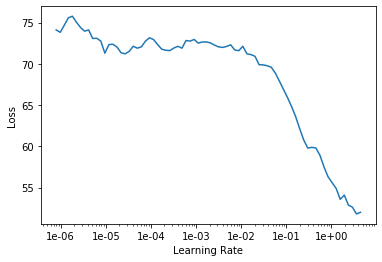

In [0]:
n_h = 5

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    nn.Linear(n_h,1),
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.data.batch_size = 128
learn.fit_one_cycle(40,1e-1)

epoch,train_loss,valid_loss,time
0,70.731834,76.428757,00:00
1,68.710381,69.910179,00:00
2,64.871376,59.235077,00:00
3,59.953876,46.250099,00:00
4,54.328396,33.832169,00:00
5,47.085575,11.428310,00:00
6,38.606926,1.917472,00:00
7,32.274178,5.042281,00:00
8,27.281101,1.067654,00:00
9,23.083757,2.064368,00:00


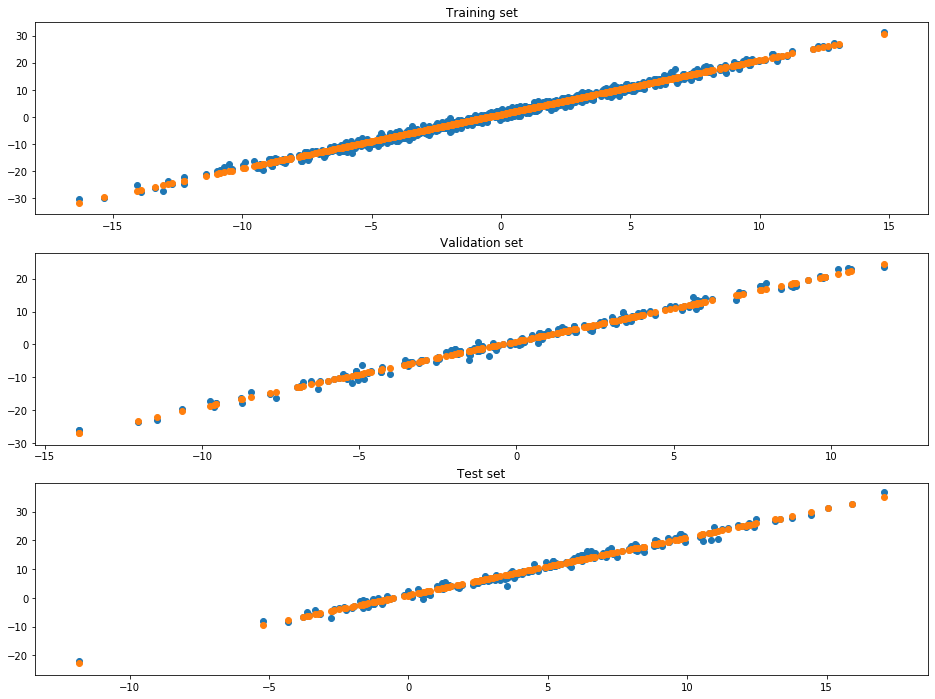

In [0]:
plot_learn(learn)

#### Regular Dropout

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


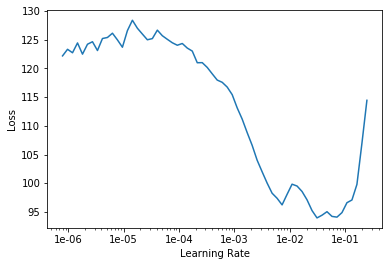

In [0]:
n_h = 1000
p = 0.95

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    nn.Dropout(p=0.95),
    nn.Linear(n_h,1),
)
model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,time
0,130.055801,68.243797,00:00
1,110.101524,43.274380,00:00
2,93.076927,14.674686,00:00
3,77.381577,3.122043,00:00
4,65.665092,1.711155,00:00
5,57.148907,1.587590,00:00
6,51.435364,1.484555,00:00
7,46.627392,1.434734,00:00
8,43.211914,1.416025,00:00
9,41.242199,1.412987,00:00


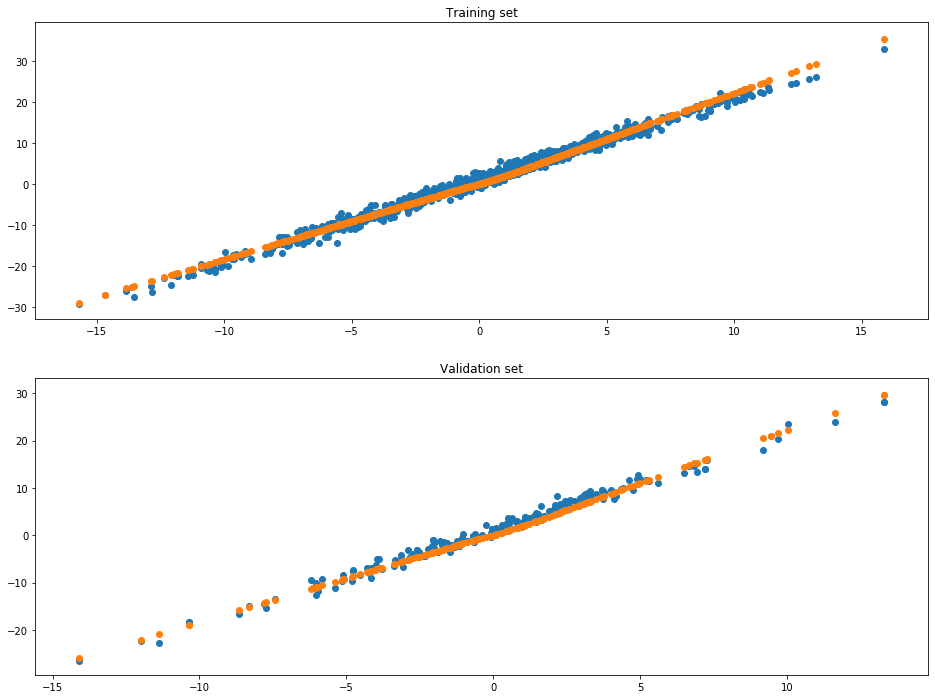

In [0]:
plot_learn(learn)

#### AutoDropout without grad

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


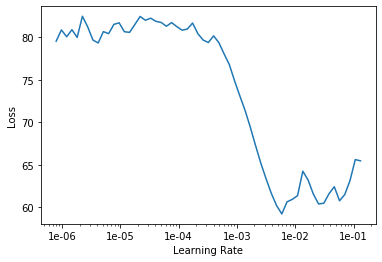

In [0]:
n_h = 1000
p = 0.5

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    AutoDropout(p=p),
    nn.Linear(n_h,1),
)
model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,time
0,82.120422,53.306286,00:00
1,74.000153,23.481150,00:00
2,56.722832,6.758641,00:00
3,41.881523,1.319473,00:00
4,32.241409,1.282382,00:00
5,26.092934,3.741612,00:00
6,21.532736,7.969058,00:00
7,18.185310,1.421633,00:00
8,15.551932,4.191690,00:00
9,13.671819,1.961052,00:00


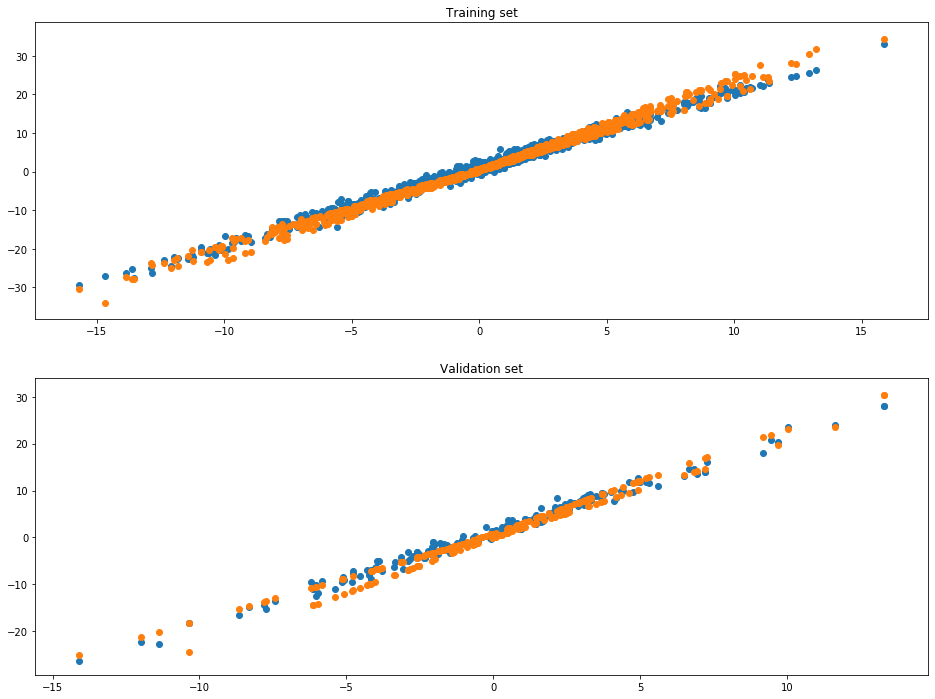

In [0]:
plot_learn(learn)

#### AutoDropout with grad

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


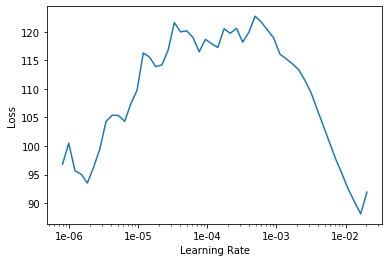

In [0]:
n_h = 1000
p = 0.90

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    AutoDropout(p=p,requires_grad=True),
    nn.Linear(n_h,1),
)
model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
recorder = AutoDropoutRecorder(learn)
learn.fit_one_cycle(10,1e-3 / 2,callbacks=[recorder])
learn.fit_one_cycle(10,1e-3 / 2,callbacks=[recorder])
learn.fit_one_cycle(10,1e-3 / 2,callbacks=[recorder])

epoch,train_loss,valid_loss,time
0,119.120232,104.024391,00:00
1,134.035172,127.108704,00:00
2,125.396431,50.796230,00:00
3,109.967361,49.810558,00:00
4,101.744102,37.669048,00:00
5,87.161011,35.629116,00:00
6,77.293648,41.451893,00:00
7,69.294601,27.941338,00:00
8,63.217342,29.101778,00:00
9,58.281551,17.917830,00:00


epoch,train_loss,valid_loss,time
0,45.672062,16.948830,00:00
1,35.732704,20.748369,00:00
2,40.124531,13.616682,00:00
3,38.890556,16.569246,00:00
4,35.050106,3.372812,00:00
5,29.607147,19.333908,00:00
6,25.185953,9.823825,00:00
7,22.382936,2.598997,00:00
8,19.898941,5.992350,00:00
9,19.151438,9.059778,00:00


epoch,train_loss,valid_loss,time
0,14.306240,11.597147,00:00
1,13.351448,4.161166,00:00
2,11.451623,30.271233,00:00
3,12.863500,41.794308,00:00
4,14.496570,8.984091,00:00
5,13.965285,9.981429,00:00
6,13.265311,5.801673,00:00
7,12.788558,6.304476,00:00
8,11.606328,6.830964,00:00
9,10.763448,7.480687,00:00


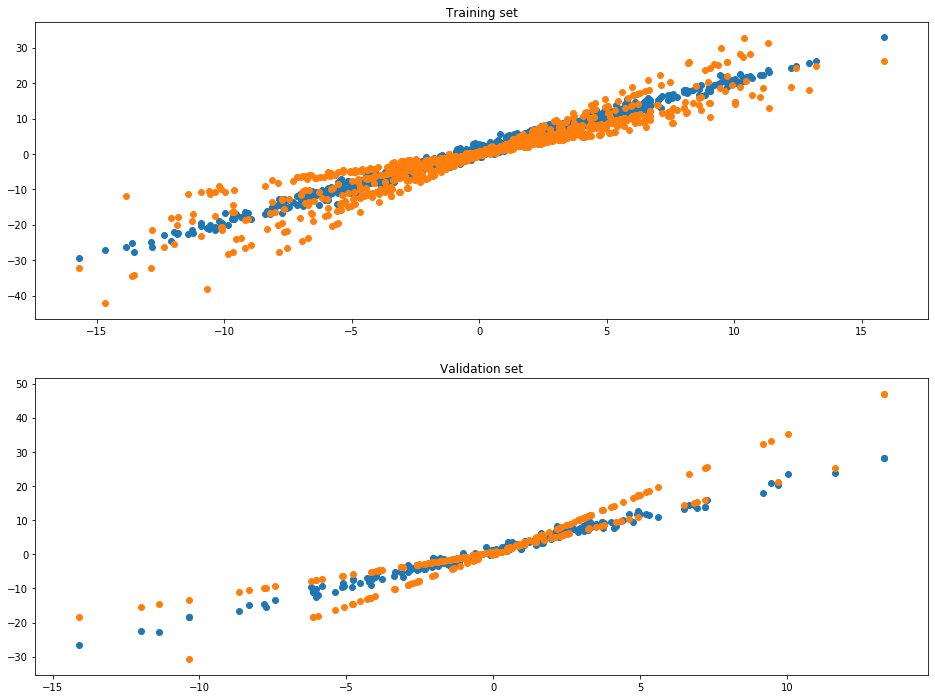

In [0]:
plot_learn(learn)

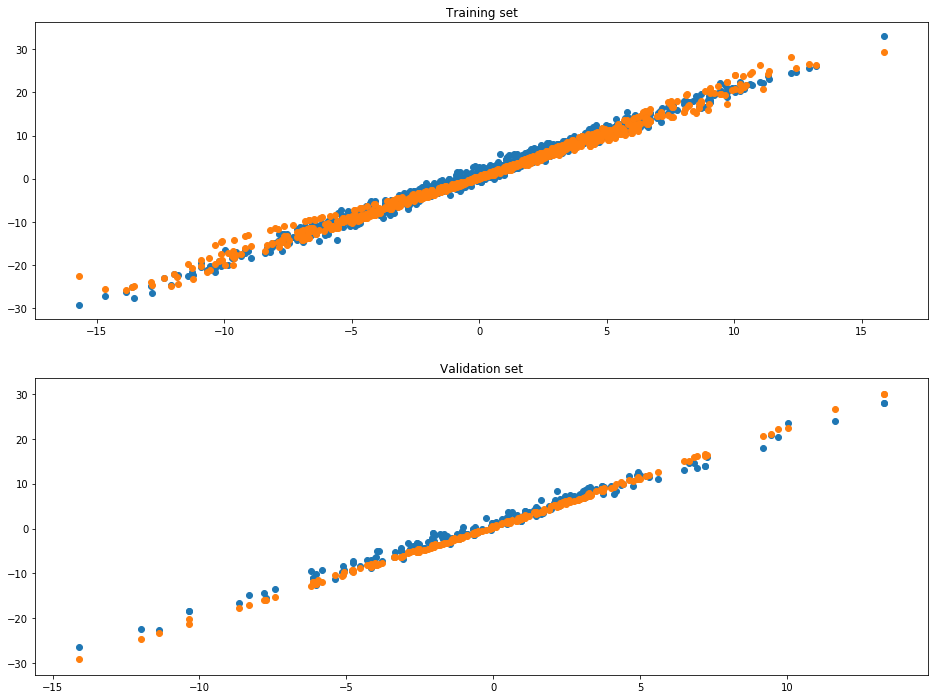

In [0]:
plot_learn(learn,n_sample=10)

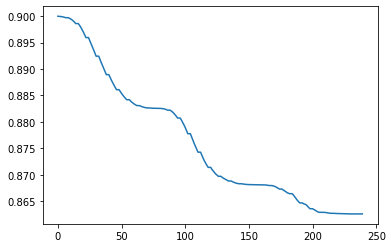

In [0]:
key = list(recorder.ps.keys())[0]
vals = recorder.ps[key]
plt.plot(vals)

### Polynomial case

In [0]:
n = 200
A = 3

fn = lambda x : x ** 3 - x + 1

data = make_data(fn=fn,A=A,n=n,sigma=10)

loss = lambda pred,y : F.mse_loss(pred.squeeze(1),y)

In [0]:
x = data.valid_ds.x.conts.reshape(-1)
y = data.valid_ds.y.items.reshape(-1)

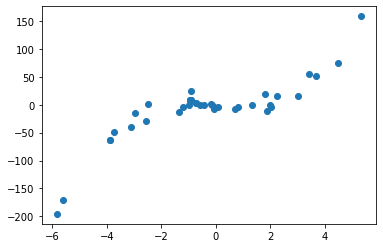

In [0]:
plt.scatter(x,y)

#### No dropout

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


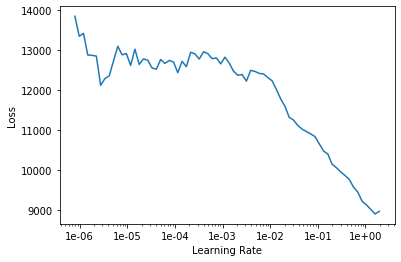

In [0]:
n_h = 1000
p = 0

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    nn.Linear(n_h,1)
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
from fastai.callbacks.hooks import ActivationStats

In [0]:
cb = ActivationStats(learn)
learn.fit_one_cycle(75,1,callbacks=cb)

epoch,train_loss,valid_loss,time
0,8086.566406,1037.751587,00:00
1,6131.620117,3400.283691,00:00
2,5628.384277,2275.072754,00:00
3,5672.347656,946.037964,00:00
4,5169.135742,470.607605,00:00
5,4921.655762,294.129456,00:00
6,4449.604980,1824.354492,00:00
7,4194.937988,651.736633,00:00
8,3940.458740,348.422943,00:00
9,3747.585205,1155.277344,00:00


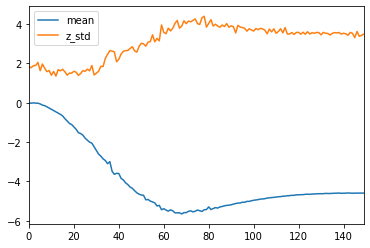

In [0]:
z_mean = cb.stats[0][0]
z_std = cb.stats[1][0]
df = pd.DataFrame({"mean":z_mean,"z_std":z_std})
df.plot()

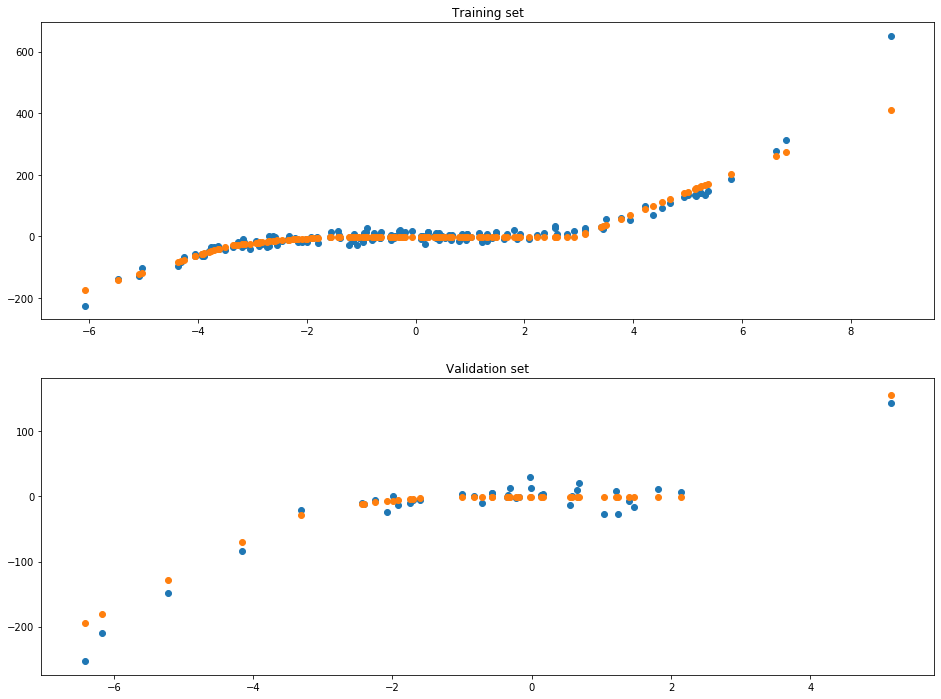

In [0]:
plot_learn(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


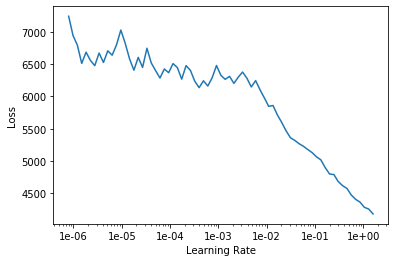

In [0]:
n_h = 1000
p = 0

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    nn.Linear(n_h,1)
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(75,1e-2)

epoch,train_loss,valid_loss,time
0,3126.824463,4080.455566,00:00
1,5348.083984,4023.741455,00:00
2,4687.789551,3950.333984,00:00
3,5381.074219,3851.727295,00:00
4,5041.876465,3725.110596,00:00
5,5310.113281,3563.341309,00:00
6,4965.338867,3370.324951,00:00
7,4597.144043,3148.774902,00:00
8,4751.994629,2895.014160,00:00
9,4430.328613,2618.991699,00:00


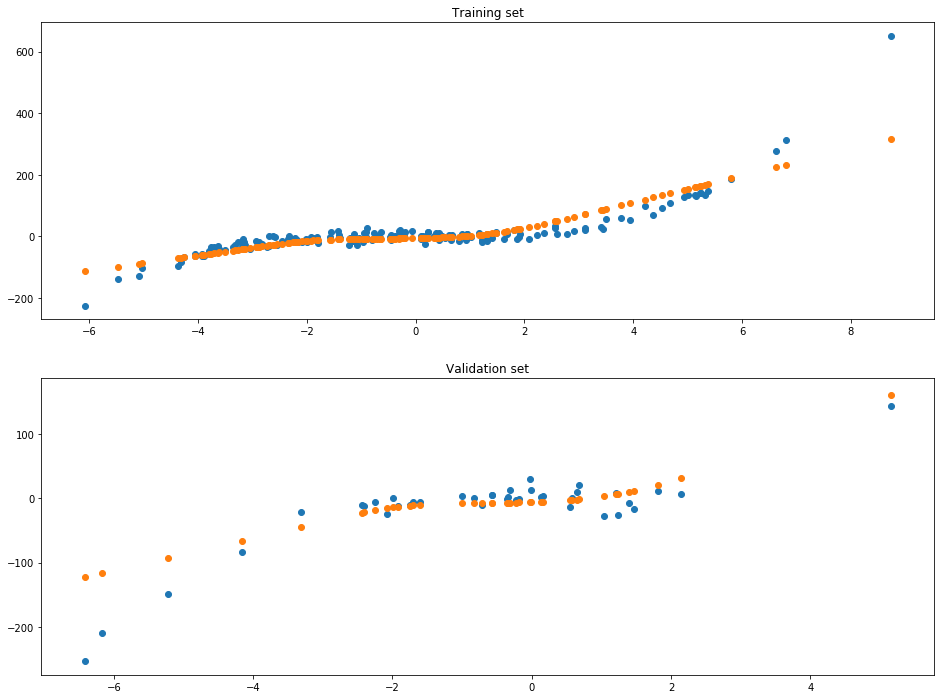

In [0]:
plot_learn(learn)

#### AutoDropout without grad

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


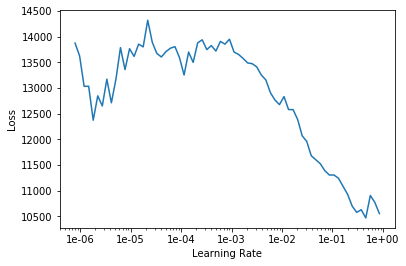

In [0]:
n_h = 1000
p = 0.5

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    AutoDropout(p=p),
    nn.Linear(n_h,1)
)
model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
cb = ActivationStats(learn)
learn.fit_one_cycle(75,1e-1,callbacks=cb)

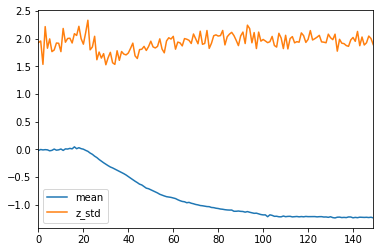

In [0]:
z_mean = cb.stats[0][0]
z_std = cb.stats[1][0]
df = pd.DataFrame({"mean":z_mean,"z_std":z_std})
df.plot()

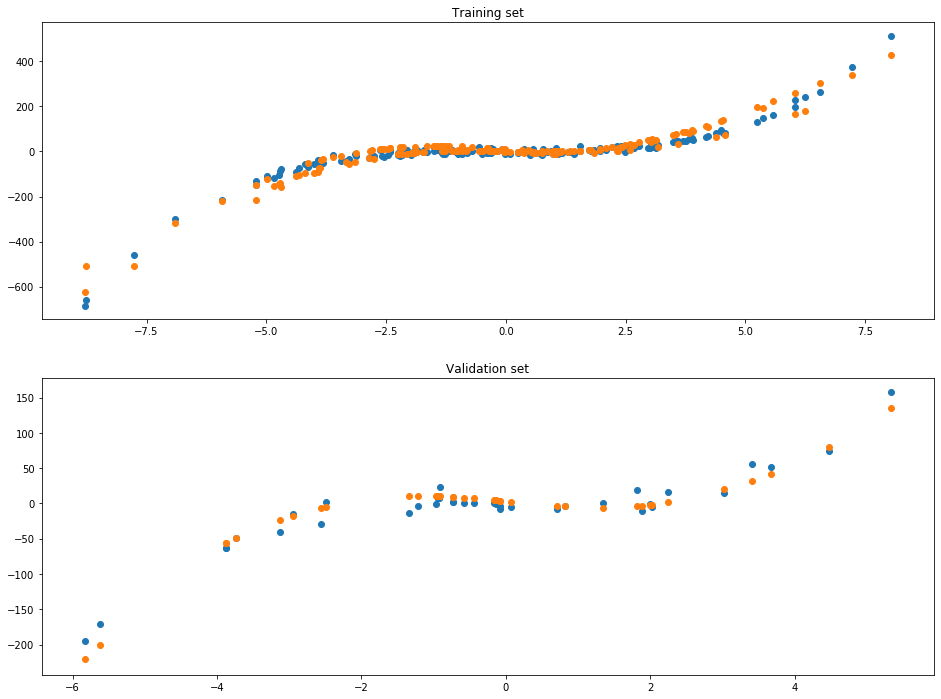

In [0]:
plot_learn(learn)

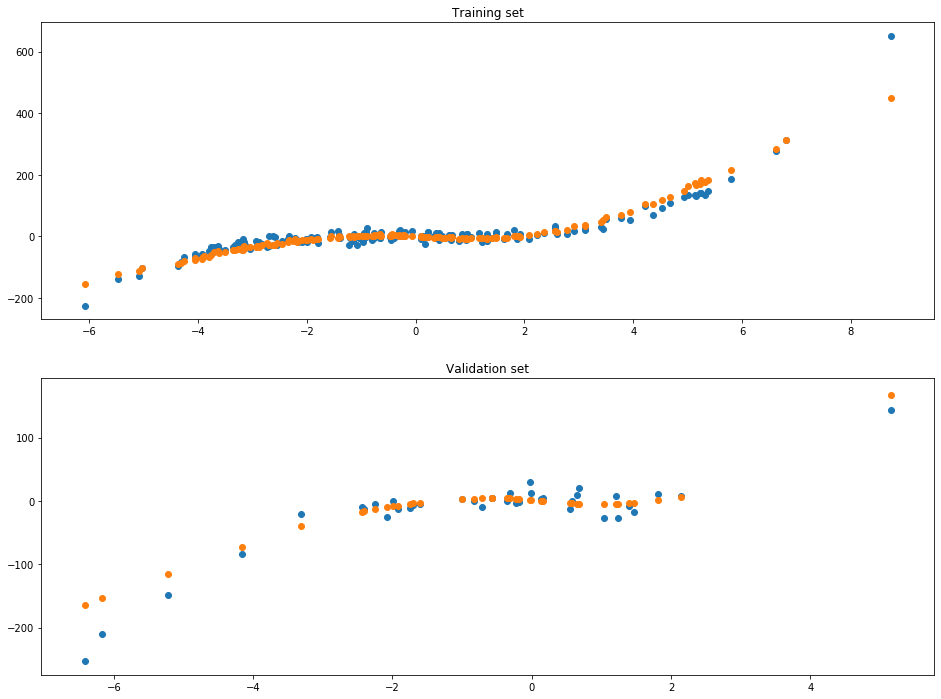

In [0]:
plot_learn(learn,n_sample=20)

#### AutoDropout with grad

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5304af0438>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 882, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


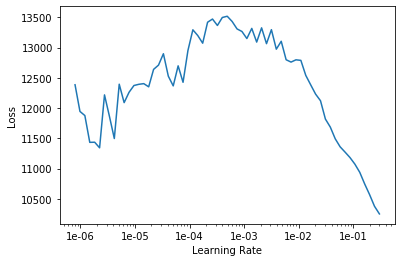

In [0]:
n_h = 1000
p = 0.5
requires_grad = True

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    AutoDropout(p=p,requires_grad=requires_grad),
    nn.Linear(n_h,1)
)
model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.model.model[0].weight.data.std()

tensor(0.5257, device='cuda:0')

In [0]:
recorder = AutoDropoutRecorder(learn)
cb = ActivationStats(learn)
learn.fit_one_cycle(75,1e-1,callbacks=[cb,recorder])

epoch,train_loss,valid_loss,time
0,13054.254883,2685.241699,00:00
1,13721.828125,2353.103027,00:00
2,13784.943359,1968.837646,00:00
3,11797.772461,1617.759155,00:00
4,10459.869141,1159.413086,00:00
5,10180.881836,908.061523,00:00
6,9584.646484,1209.594727,00:00
7,8869.858398,2216.200195,00:00
8,8322.778320,3348.493652,00:00
9,8024.081055,3958.280518,00:00


RuntimeError: ignored

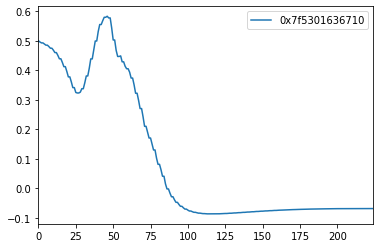

In [0]:
recorder.plot()

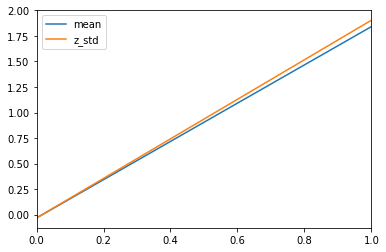

In [0]:
z_mean = cb.stats[0][0]
z_std = cb.stats[1][0]
df = pd.DataFrame({"mean":z_mean,"z_std":z_std})
df.plot()

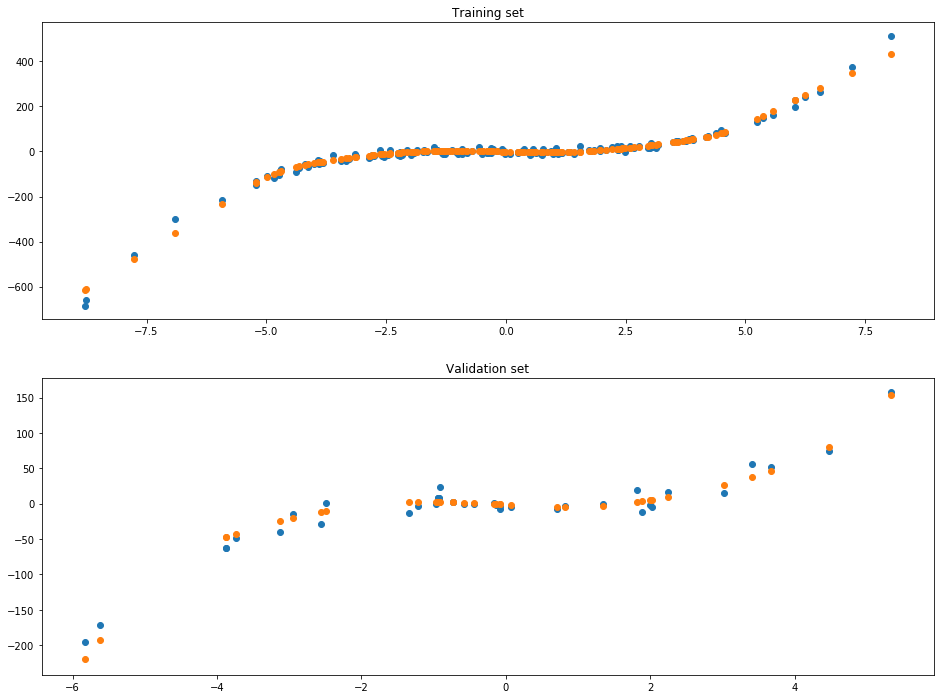

In [0]:
plot_learn(learn)

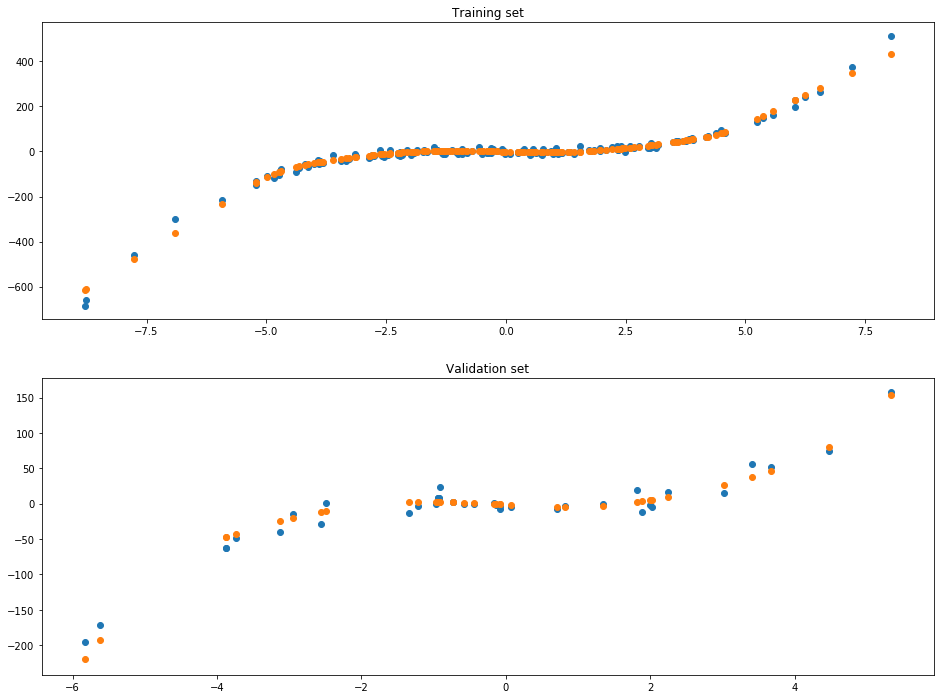

In [0]:
plot_learn(learn,n_sample=10)

### Sinus of exponential

In [0]:
n = 10000
n_epoch = 150
A = 5

fn = lambda x : x * np.sin(x) - 1

data = make_data(fn)

loss = lambda pred,y : F.mse_loss(pred.squeeze(1),y)

In [0]:
x = data.valid_ds.x.conts
y = data.valid_ds.y.items

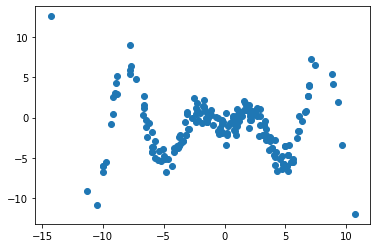

In [0]:
plt.scatter(x,y)

#### No dropout

##### Shallow NN

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


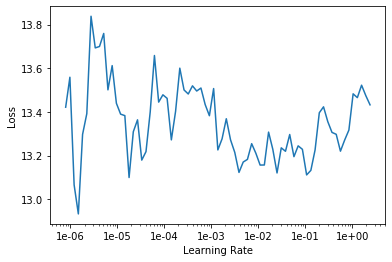

In [0]:
n_h = 5
p = 0

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    nn.Linear(n_h,1)
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

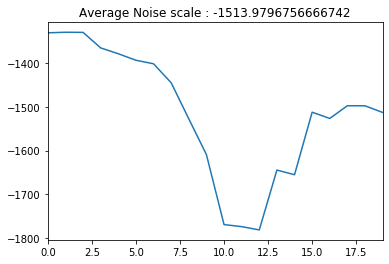

In [0]:
lr = 1e-1 / 2
bs = 64
num_it = 400
n_batch = 20
beta = 0.99

cb = bs_find(learn,lr=lr,bs=bs,num_it=num_it,n_batch=n_batch,beta=beta)
cb.plot()

In [0]:
df = pd.DataFrame(cb.output)
df[["g_big","g_small"]].iloc[0]["g_big"].item()

0.005769877228885889

In [0]:
learn.fit_one_cycle(n_epoch,1e-1 / 2)

epoch,train_loss,valid_loss,time
0,13.165648,11.377428,00:00
1,13.178855,11.384348,00:00
2,13.220552,11.363642,00:00
3,13.079877,11.335154,00:00
4,12.999738,11.275679,00:00
5,13.079383,11.217847,00:00
6,13.227422,11.206404,00:00
7,13.263635,11.216131,00:00
8,13.321794,11.189536,00:00
9,13.322402,11.132051,00:00


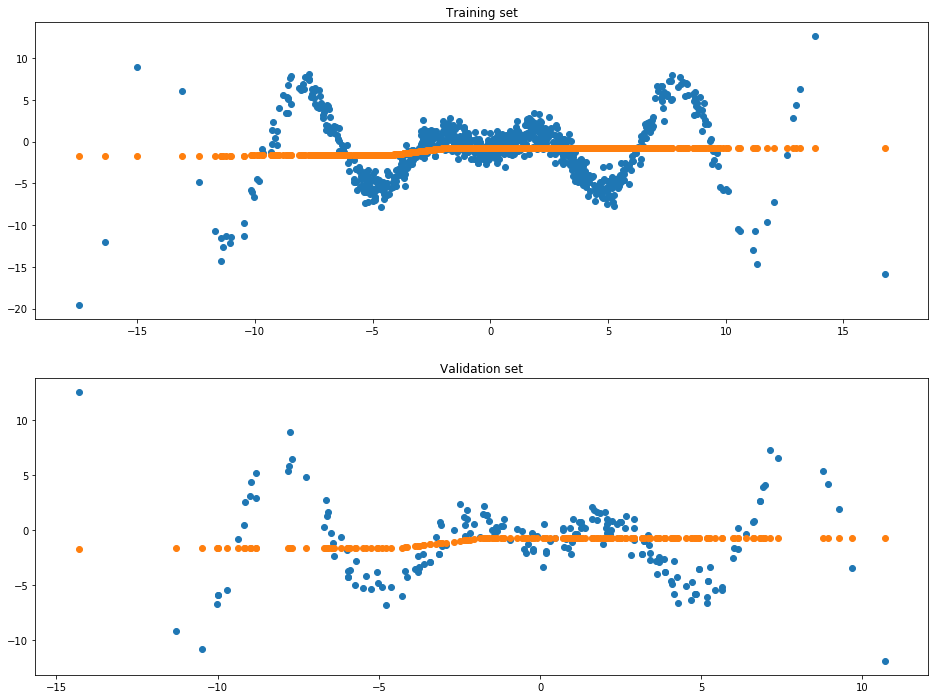

In [0]:
plot_learn(learn)

##### Deep NN

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


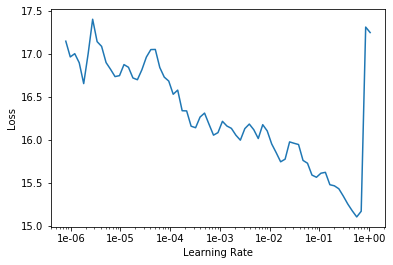

In [0]:
n_h = 100
p = 0

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    nn.Linear(n_h,n_h // 2),
    nn.ReLU(),
    nn.Linear(n_h // 2,1)
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,15.498716,#na#,00:00
1,14.998234,#na#,00:00
2,14.582521,#na#,00:00
3,14.649223,#na#,00:00
4,14.528502,#na#,00:00
5,14.339689,#na#,00:00
6,14.213932,#na#,00:00
7,14.111204,#na#,00:00
8,14.216688,#na#,00:00
9,14.355974,#na#,00:00


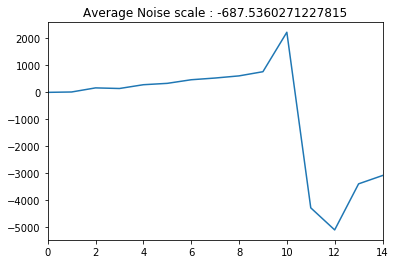

In [0]:
args = {"bs" : 32, "num_it" : 300,"beta":0.999}

bs_find(learn,lr=1e-3,**args).plot()

In [0]:
learn.data.batch_size = 64
learn.fit_one_cycle(100,1e-3)
learn.fit_one_cycle(100,1e-3)

epoch,train_loss,valid_loss,time
0,16.200153,18.055830,00:00
1,16.124161,17.813129,00:00
2,15.935051,17.614338,00:00
3,15.650845,17.447546,00:00
4,15.436625,17.347187,00:00
5,15.253540,17.346104,00:00
6,15.020268,17.403254,00:00
7,14.895159,17.391582,00:00
8,14.794923,17.507042,00:00
9,14.690225,17.601526,00:00


epoch,train_loss,valid_loss,time
0,12.073440,13.920555,00:00
1,12.039734,13.907156,00:00
2,11.851196,13.884517,00:00
3,12.041327,13.881060,00:00
4,12.120786,13.951691,00:00
5,12.064458,13.911189,00:00
6,11.993559,13.861791,00:00
7,12.015585,13.716949,00:00
8,11.915249,13.632316,00:00
9,11.950657,13.783116,00:00


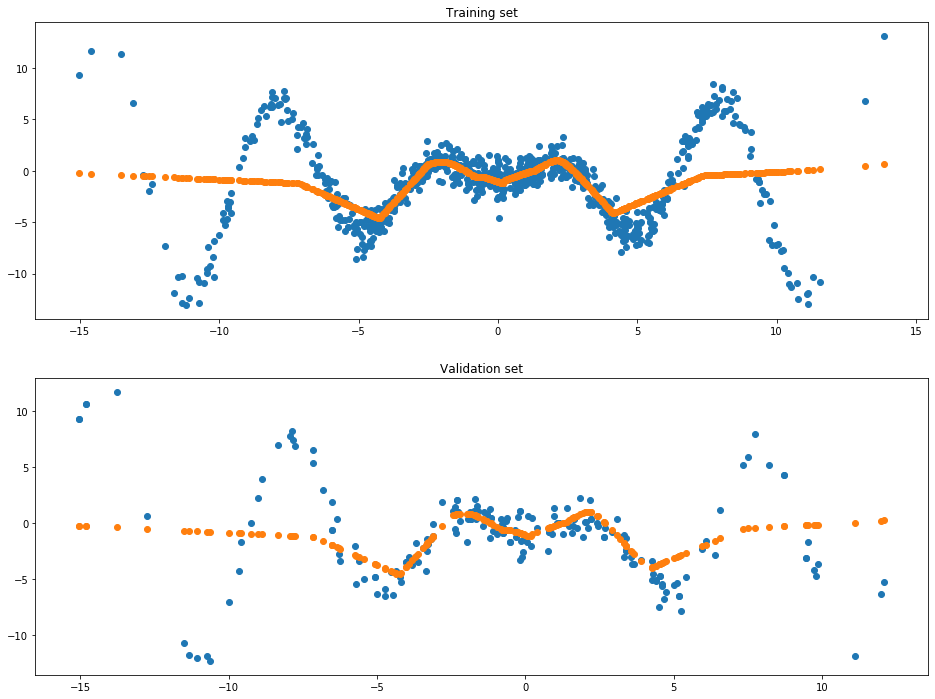

In [0]:
plot_learn(learn)

##### AutoDropout without grad

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


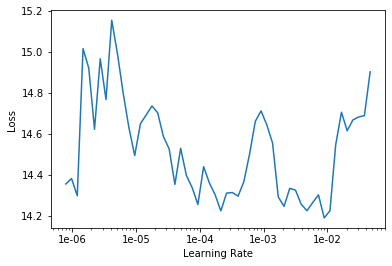

In [0]:
n_h = 250
p = 0.5

regressor = nn.Sequential(
    nn.Linear(1,n_h),
    nn.ReLU(),
    AutoDropout(p=p),
    nn.Linear(n_h,n_h // 2),
    nn.ReLU(),
    AutoDropout(p=p),
    nn.Linear(n_h // 2,1)
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(n_epoch,1e-3)

epoch,train_loss,valid_loss,time
0,14.284987,11.669065,00:00
1,14.651676,12.647952,00:00
2,14.335998,12.619529,00:00
3,14.168332,11.269337,00:00
4,14.107512,11.405449,00:00
5,13.991996,11.555855,00:00
6,13.998107,13.930375,00:00
7,14.139343,11.509286,00:00
8,14.071052,12.244353,00:00
9,14.031098,12.310763,00:00


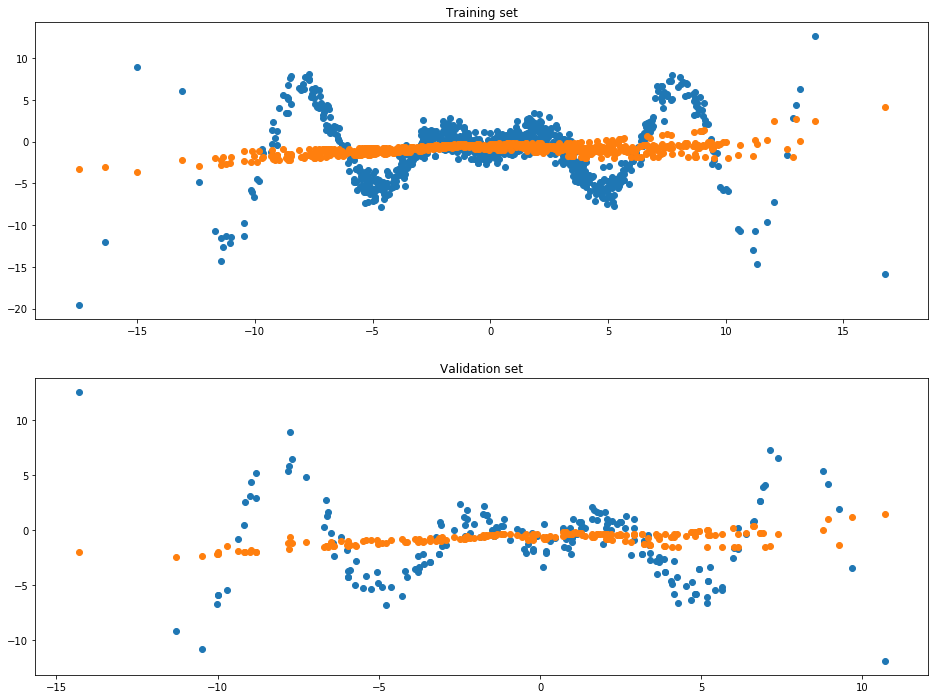

In [0]:
plot_learn(learn)

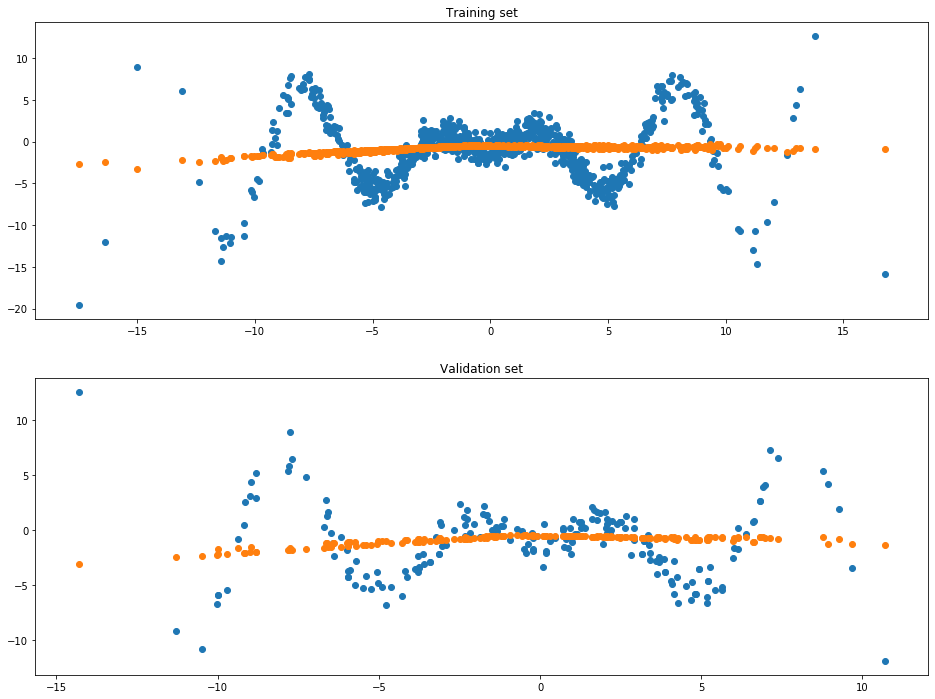

In [0]:
plot_learn(learn,n_sample=10)

# KL Dropout

In [0]:
from fastai.callbacks.hooks import HookCallback
from fastai.torch_core import to_np

norm2 = lambda x : (x**2).sum()
neg_entropy = lambda p : p * torch.log(p) + (1-p) * torch.log(1-p)

def get_layer(m,buffer,layer):
    """Function which takes a list and a model append the elements"""
    for c in m.children():
        if isinstance(c,layer):
            if isinstance(buffer,list):
              buffer.append(c)
            elif isinstance(buffer,dict):
              i = hex(id(c))
              buffer[i] = c
        get_layer(c,buffer,layer)

class PLU(nn.Module):
  """Probability Linear Unit"""
  def __init__(self):
    super(PLU,self).__init__()
  
  def forward(self,x):
    z = torch.clamp(x,0,1)
    return z    
  
class AutoDropout(nn.Module):
    def __init__(self,dp=0.,requires_grad=False):
        
        super(AutoDropout,self).__init__()
        
        # We transform the dropout rate to keep rate
        p = 1 - dp
        p = torch.tensor(p)
        
        self.plu = PLU()
        
        if requires_grad: 
            p = nn.Parameter(p)
            self.register_parameter("p",p)
        else:
            self.register_buffer("p",p)
    
    def forward(self,x):
        bs,shape = x.shape[0], x.shape[1:]
        
        # We make sure p is a probability
        p = self.plu(self.p)

        # We sample a mask
        m = Bernoulli(p).sample(shape)

        # Element wise multiplication
        z = x * m

        return z

class DropLinear(nn.Module):
    def __init__(self,in_features,out_features,dp=0.,bias=True,requires_grad=False):
        super(DropLinear,self).__init__()
        
        self.dp = AutoDropout(dp=dp,requires_grad=requires_grad)
        self.W = nn.Linear(in_features=in_features,out_features=out_features,bias=bias)
        self.W.weight.data = self.W.weight.data / self.W.weight.data.norm() * (1-dp)
        
    def forward(self,x):
        z = self.W(x)
        z = self.dp(z)
        return z

class CustomActivationStats(HookCallback):
    def __init__(self, learn, layer_type,do_remove:bool=True):
        super().__init__(learn)
        
        buffer = []
        get_layer(learn.model,buffer,layer_type)
        if not buffer:
            raise NotImplementedError(f"No {layer_type} Linear found")
            
        self.modules = buffer
        self.do_remove = do_remove
        
        self.stats = []
        
    def hook(self,m,i,o):
        mean = o.mean().item()
        std = o.std().item()
        z = to_np(o.mean(dim=0))
        
        i = hex(id(m))
        self.stats.append({"m": mean,"s":std,"z":z,"module":i})
    
    @property    
    def df(self): return pd.DataFrame(self.stats)
        
class KLHook(HookCallback):
    """Hook to register the parameters of the latents during the forward pass to compute the KL term of the VAE"""
    def __init__(self, learn, do_remove:bool=True,recording=False):
        super().__init__(learn)
        
        # First we store all the DropLinears layers to hook them 
        buffer = []
        get_layer(learn.model,buffer,DropLinear)
        if not buffer:
            raise NotImplementedError(f"No {DropLinear} Linear found")
            
        self.modules = buffer
        self.do_remove = do_remove
        
        # We will store the KL of each DropLinear here before summing them
        self.kls = []
        
        self.recording = recording
        
        if recording:
          self.stats = []
          self.loss = []
    
    def on_backward_begin(self,last_loss,**kwargs):
        
        total_kl = torch.tensor(self.kls).sum()
        total_loss = last_loss + total_kl
        
        if self.recording:
          self.loss.append({"total_kl":total_kl.item(),"last_loss":last_loss.item(),
                            "total_loss":total_loss.item()})
        
        # We empty the buffer of kls
        self.kls = []
        
        return {"last_loss" : total_loss}
        
    def hook(self, m:nn.Module, i, o):
        "Save the latents of the bottleneck"
        p = m.dp.p
        p = m.dp.plu(p)
        
        ne = neg_entropy(p)
        
        W = m.W.weight
        norm_w = norm2(W)
        
        b = m.W.bias
        norm_b = norm2(b)
        
        kl = p * norm_w + ne + norm_b    
        
        self.kls.append(kl)
        
        if self.recording:
          i = hex(id(m))
          self.stats.append({"dropout":1 - p.item(),"w":norm_w.item(),"ne":ne.item(),"module":i})
    
    @property
    def df_stats(self): return pd.DataFrame(self.stats)
    
    @property
    def df_loss(self): return pd.DataFrame(self.loss)
    
    def plot_stats(self,module=None):
        assert self.recording, "Recording mode was off during initialization"
        df = self.df_stats
        if module: df = df.loc[df.module == module]
        
        fig,ax = plt.subplots(3,1,figsize=(16,12))
        
        ax[0].plot(df.w.values)
        ax[0].set_title("Weight norm")
        
        ax[1].plot(df.dropout.values)
        ax[1].set_title("Dropout rate")
        
        ax[2].plot(df["ne"].values)
        ax[2].set_title("Negative entropy")
        
    def plot_losses(self):
        assert self.recording, "Recording mode was off during initialization"
        df = self.df_loss
        df.plot()
        

In [0]:
n = 1000
A = 3

fn = lambda x : x ** 3 - x + 1

data = make_data(fn=fn,A=A,n=n,sigma=10)

loss = lambda pred,y : F.mse_loss(pred.squeeze(1),y)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


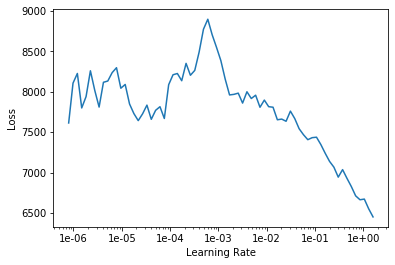

In [0]:
n_h = 1000
dp = 0.05

regressor = nn.Sequential(
    DropLinear(1,n_h,dp=dp,requires_grad=True),
    nn.ReLU(),
    nn.Linear(n_h,1)
)

model = TabularModel(regressor)

learn = Learner(data=data,model=model,loss_func=loss)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
kl = KLHook(learn,recording=True)
cb = CustomActivationStats(learn,layer_type=DropLinear)

cbs = [kl,cb]

learn.fit_one_cycle(75,1e-1,callbacks=cbs)

epoch,train_loss,valid_loss,time
0,7825.162598,9974.252930,00:00
1,7490.922852,8840.105469,00:00
2,6920.869141,6697.409180,00:00
3,6102.657227,5205.656250,00:00
4,5625.473145,5325.130859,00:00
5,5171.336426,5156.394531,00:00
6,4813.883789,4412.290527,00:00
7,4377.091797,3629.710205,00:00
8,3959.536377,2828.725830,00:00
9,3495.277832,2305.418701,00:00


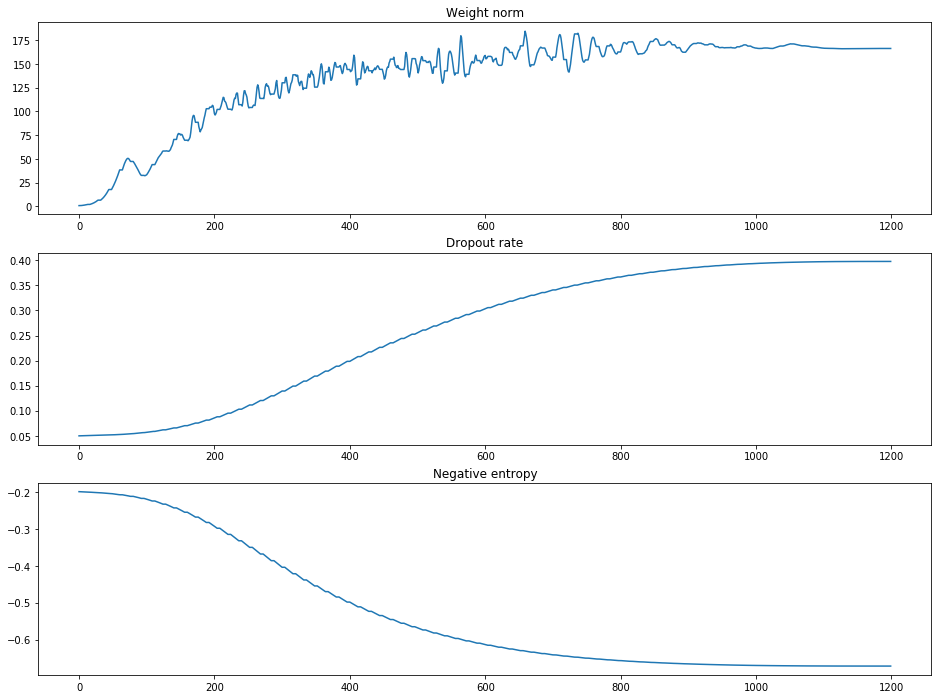

In [0]:
kl.plot_stats()

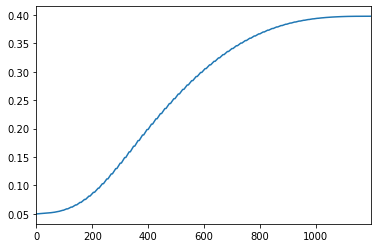

In [0]:
kl.df_stats.dropout.plot()

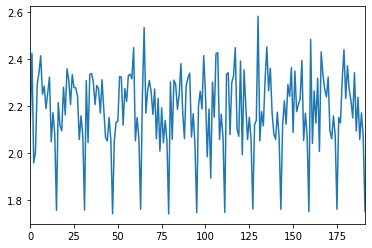

In [0]:
df.s.plot()

In [0]:
values = np.stack(df.z.values)

i = 1000

row = values[i]
plt.hist(row[row !=  0])

IndexError: ignored

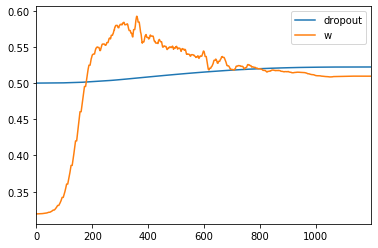

In [0]:
kl.plot_stats()

In [0]:
df = pd.DataFrame(kl.loss)
df

,total_kl,last_loss,total_loss
0,-0.608479,10584.292969,10583.684570
1,-0.608476,18589.269531,18588.660156
2,-0.608472,4405.199219,4404.590820
3,-0.608468,11450.361328,11449.752930
4,-0.608463,9786.327148,9785.718750
...,...,...,...
895,-0.569733,288.764160,288.194427
896,-0.569733,1112.039062,1111.469360
897,-0.569733,647.168335,646.598572
898,-0.569733,372.070312,371.500580


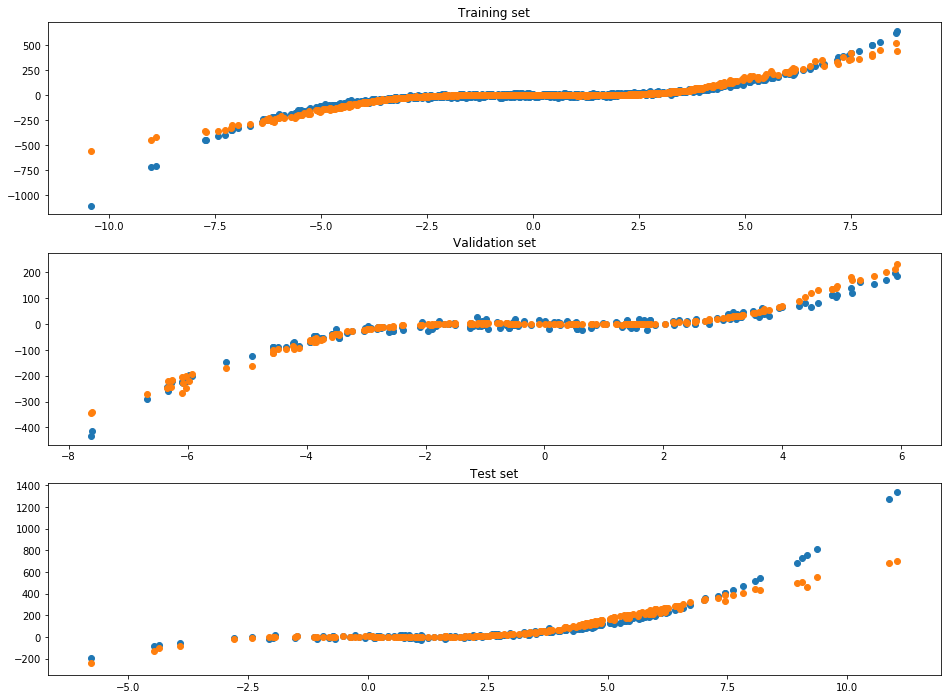

In [0]:
plot_learn(learn)

## Rossmann stores

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = Path("/content/drive/My Drive/rossmann")

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [0]:
procs=[FillMissing, Categorify, Normalize]

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [0]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
def convert_layers(model,original,replacement,get_args=None,additional_args=None,final_layer_id=None):
    for child_name, child in model.named_children():
        i = hex(id(child))
        if isinstance(child, original) and i != final_layer_id:
            if get_args: 
              original_args = get_args(child)
            else:
              original_args = {}
            
            # If we want to provide additional args
            if additional_args: 
              args = {**orginal_args,**additional_args}
            else:
              args = original_args
            
            old_layer = getattr(model,child_name)
            new_layer = replacement(**args)
            
            setattr(model, child_name, new_layer)
        else:
            convert_layers(child,original,replacement,get_args,additional_args,final_layer_id)

def remove_layers(model,m_to_del):
  to_del = []
  for k,c in model._modules.items():
    if isinstance(c,m_to_del):
      to_del.append(k)
  for k in to_del:
    del model._modules[k]

get_args = lambda lin : {"in_features":lin.in_features, "out_features":lin.out_features}

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)


In [0]:
final_layer_id = hex(id(learn.model.layers[-1]))

In [0]:
additional_args = {
    "requires_grad" : True,
    "dp" : 0.05,
}

convert_lin_to_droplin = partial(convert_layers,original = nn.Linear,replacement = DropLinear,get_args=get_args,additional_args=additional_args,
                                final_layer_id=final_layer_id)

In [0]:
print(count_parameters(learn.model))
remove_layers(learn.model.layers,nn.Dropout)
b = count_parameters(learn.model)
print(b)
convert_lin_to_droplin(learn.model)
a = count_parameters(learn.model)
print(b - a)

831054
831054
-2


In [0]:
learn.model.cuda()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): DropLinear(
      (dp): AutoDropout(
        (plu): PLU()
      )
      (W): Linear(in_features=233, out_features=1000, bias=True)
    )
    (1): ReLU(inplac

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


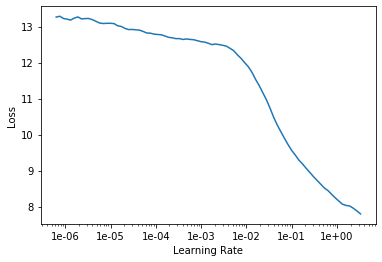

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
kl = KLHook(learn,recording=True)
cb = CustomActivationStats(learn,layer_type=DropLinear)

cbs = [kl,cb]


epoch,train_loss,valid_loss,exp_rmspe,time
0,0.019500,0.385759,0.444655,01:39


In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.05,0.05], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)
learn.data.batch_size = 512

In [0]:
class CustomDropout(nn.Module):
  def __init__(self,p,activate=True):
    super().__init__()
    self.activate = activate
    self.p = p
    
  def forward(self,x):
    return nn.functional.dropout(x,self.p,training=self.activate)

In [0]:
get_args = lambda dp : {"p":dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args=get_args)

In [0]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [81]                 90,396     True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [7]                  91         True      
______________________________________________________________________
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [10]                 260        True      
_________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


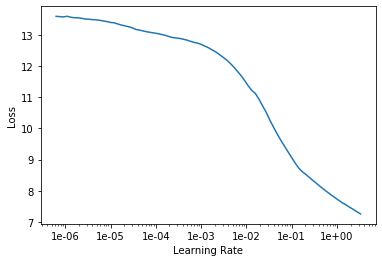

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3,)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.082807,0.105385,0.322152,00:47
1,0.023083,0.024727,0.165047,00:46
2,0.017177,0.017222,0.147268,00:45
3,0.012182,0.015136,0.130101,00:45
4,0.010656,0.015765,0.138053,00:46


In [0]:
learn.save("model_regular_dp")

In [0]:

x,y = learn.data.one_batch(cpu=False)

In [0]:
pred,y = get_preds_sample(learn,n_sample=10)

In [0]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [81]                 90,396     True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [7]                  91         True      
______________________________________________________________________
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [10]                 260        True      
_________________________________________________

In [0]:
exp_rmspe(pred.mean(dim=0).squeeze(1),y)

tensor(0.1339)

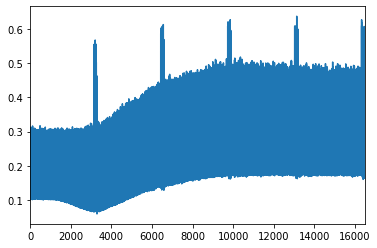

In [0]:
df = pd.DataFrame(cb.stats)
df.s.plot()

In [0]:
df.module.unique()

array(['0x7fa2e6b2a358', '0x7fa2e2d2ec18'], dtype=object)

(array([ 2.,  2., 21., 34., 45., 61., 38., 30., 14.,  7.]),
 array([-1.412846, -1.116899, -0.820951, -0.525004, -0.229057,  0.06689 ,  0.362837,  0.658785,  0.954732,  1.250679,
         1.546626], dtype=float32),
 <a list of 10 Patch objects>)

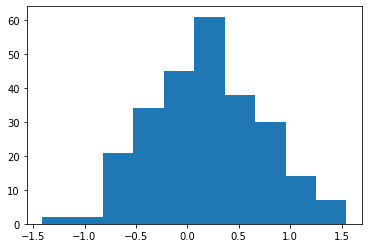

In [0]:
values = np.stack(df.loc[df.module == "0x7fa2e2d2ec18","z"])

i = 

row = values[i]
plt.hist(row[row !=  0])

In [0]:
df.module.unique()

array(['0x7fa2e6b2a358', '0x7fa2e2d2ec18'], dtype=object)

In [0]:
df.w

0        0.001430
1        0.000333
2        0.001430
3        0.000333
4        0.001430
           ...   
16485    0.000333
16486    0.001430
16487    0.000333
16488    0.001430
16489    0.000333
Name: w, Length: 16490, dtype: float64

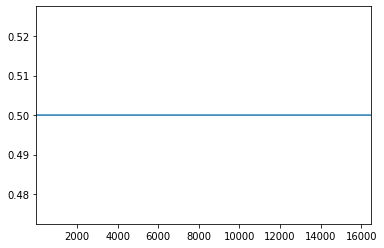

In [0]:
df = pd.DataFrame(kl.stats)
df.loc[df.module == "0x7fa2e2d2ec18","dropout"].plot()

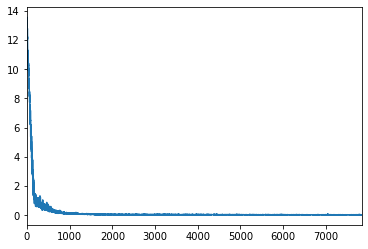

In [0]:
df = pd.DataFrame(kl.loss)
df.last_loss.plot()